# State Estimation for NMC Battery Data
This notebook demonstrates the process of state estimation from battery data collected from the [CAMP Facility](https://www.anl.gov/cse/cell-analysis-modeling-and-prototyping-camp-facility) and published at the [Materials Data Facility](https://doi.org/10.18126/fdxq-7yul).

In [1]:
%matplotlib inline
from moirae.estimators.online.joint import JointEstimator
from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm.components import Resistance, OpenCircuitVoltage, MaxTheoreticalCapacity, ReferenceOCV
from moirae.simulator import Simulator
from moirae.models.ecm import ECMASOH, ECMTransientVector, ECMInput, ECMMeasurement
from moirae.interface import run_online_estimate
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from batdata.data import BatteryDataset
from shutil import copyfileobj
from pathlib import Path
import numpy as np
import requests

/Users/vventuri/python_envs/ASOH_Diagnostics/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Configuration

In [2]:
data_url = 'https://data.materialsdatafacility.org/mdf_open/camp_2023_v3.5/hdf5/refined/batch_B10A_cell_3.h5'
num_soc_steps: int = 9  # Number of interpolation steps in the OCV measurements
data_dir = Path('data')

In [3]:
data_dir.mkdir(exist_ok=True)

## Download and Parse the Data
Download the data using HTTP and store locally

In [4]:
data_path = data_dir / data_url.split("/")[-1]
print(f'Saving data to {data_path}')

Saving data to data/batch_B10A_cell_3.h5


Download if not present

In [5]:
if not data_path.exists():
    with data_path.open('wb') as fp:
        copyfileobj(requests.get(data_url, stream=True).raw, fp)

In [6]:
dataset = BatteryDataset.from_batdata_hdf(data_path)

In [7]:
dataset.metadata.model_dump(exclude_defaults=True)

{'name': 'CAMP_batch_B10A_cell_3',
 'battery': {'layer_count': 2,
  'anode': {'name': 'C',
   'supplier': 'Commercial',
   'product': 'Graphite',
   'thickness': 92.0,
   'loading': 6.75,
   'porosity': 32.2},
  'cathode': {'name': 'NMC532',
   'supplier': 'Commercial',
   'thickness': 94.0,
   'area': 785.1199999999999,
   'loading': 12.7,
   'porosity': 33.8},
  'electrolyte': {'name': 'Gen 2'},
  'nominal_capacity': 1.5},
 'dataset_name': 'camp_2023',
 'authors': [('Logan', 'Ward'),
  ('Joseph', 'Kubal'),
  ('Susan J.', 'Babinec'),
  ('Wenquan', 'Lu'),
  ('Allison', 'Dunlop'),
  ('Steve', 'Trask'),
  ('Andrew', 'Jansen'),
  ('Noah H.', 'Paulson')],
 'associated_ids': [Url('https://doi.org/10.1016/j.jpowsour.2022.231127')]}

## Get Initial Parameter Estimates for Equivalent Circuit Parameters
Let's start with some educated guesses for the parameters. 

First up, make a model for the open circuit voltage using a regular cycle

In [8]:
initial_cycles = dataset.raw_data.query('816 < cycle_number < 840')  # Get cycles after some initial tests

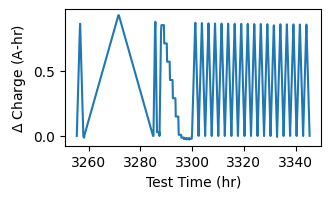

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, -initial_cycles['cycle_capacity'])

ax.set_xlabel('Test Time (hr)')
ax.set_ylabel('$\Delta$ Charge (A-hr)')
fig.tight_layout()

Estimate a capacity by getting the maximum amount of energy added to the battery

In [10]:
cycle_capacities = -initial_cycles.groupby('cycle_number')['cycle_capacity'].min()
cycle_capacities.describe()

count    23.000000
mean      0.823703
std       0.180185
min      -0.000000
25%       0.854375
50%       0.858214
75%       0.860809
max       0.924829
Name: cycle_capacity, dtype: float64

In [11]:
initial_capacity = cycle_capacities.median()
print(f'Initial capacity estimate is {initial_capacity:.2f} A-hr')

Initial capacity estimate is 0.86 A-hr


Estimate the Open Circuit Voltage by measuring the voltage at different states of charge during both charge and discharge

In [12]:
discharging = initial_cycles.query('state == "discharging"')
charging = initial_cycles.query('state == "charging"')

In [13]:
def get_voltage_measurments(subset):
    """Determine measurements at different SOCs"""

    voltage_steps = np.zeros((len(set(subset['cycle_number'])), num_soc_steps))
    for i, (_, group) in enumerate(subset.groupby('cycle_number')):
        group = group.sort_values('cycle_capacity')
        f = interp1d(-group['cycle_capacity'], group['voltage'])
        steps = np.linspace(
            -group['cycle_capacity'].max(), 
            -group['cycle_capacity'].min(),
            num_soc_steps
        )
        voltage_steps[i, :] = f(steps)
    return voltage_steps.mean(axis=0)

In [14]:
discharge_volt = get_voltage_measurments(discharging)
charge_volt = get_voltage_measurments(charging)
ocv = 0.5 * (discharge_volt + charge_volt)

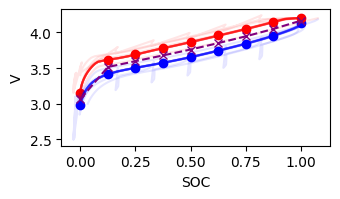

In [15]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

soc_values = np.linspace(0, 1, num_soc_steps)
for subset, points, color in [(discharging, discharge_volt, 'blue'), (charging, charge_volt, 'red')]:
    for gid, group in subset.groupby('cycle_number'):
        ax.plot(-group['cycle_capacity'] / initial_capacity, group['voltage'], alpha=0.1, color=color)
    ax.scatter(soc_values, points, marker='o', color=color)
ax.plot(soc_values, ocv, '--x', color='purple')

ax.set_xlabel('SOC')
ax.set_ylabel('V')
fig.tight_layout()

Estimate a SOC-dependent series resistance based on the difference in voltage between charge and discharge and the charge difference

$V_c - V_d = OCV + I_c R - (OCV - I_d R) = (I_c + I_d)R$

In [16]:
charge_current = charging['current'].abs().mean()
discharge_current = discharging['current'].abs().mean()
print(f'Charge current {charge_current:.1f} A. Discharge current {discharge_current:.1f} A')

Charge current 0.9 A. Discharge current 1.0 A


In [17]:
r_serial = (charge_volt - discharge_volt) / (discharge_current + charge_current)

## Create a ECM Model
Models in Moirae require definine the parameters of the system as type of `HealthVariable` class which corresponds to a certain `CellModel`.

In [18]:
asoh = ECMASOH(
    q_t=MaxTheoreticalCapacity(base_values=initial_capacity),
    r0=Resistance(base_values=r_serial),
    ocv=OpenCircuitVoltage(
        ocv_ref=ReferenceOCV(base_values=ocv),
        ocv_ent={'base_values': 0}
    )
)

The transient state of the battery system (e.g., its state of charge) is represented by a `ECMTransientVector` class.

In [19]:
ecm_start = ECMTransientVector(soc=0.)

Let's simulate a cycle then show it's pretty similar to supplied data. It will also need to now the starting inputs applied to the circuit (rest at 25C at the time at the beginning of the test).

In [20]:
simulator = Simulator(
    cell_model=ECM(),
    asoh=asoh,
    transient_state=ecm_start,
    initial_input=ECMInput(time=initial_cycles.test_time.min(), current=0, temperature=25)
)

In [21]:
sim_voltages = np.zeros((len(initial_cycles),))
sim_soc = np.zeros((len(initial_cycles),))
for j, (t, i) in enumerate(zip(initial_cycles['test_time'], initial_cycles['current'])):
    state, outputs = simulator.step(ECMInput(time=t, current=-i, temperature=25.))  # Moirae 
    sim_voltages[j] = outputs.terminal_voltage.item()  # terminal voltage is a (1, 1) array
    sim_soc[j] = state.soc.item()

Text(0, 0.5, 'Voltage')

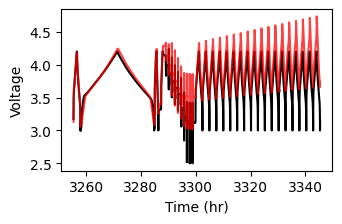

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, initial_cycles['voltage'], 'k')
ax.plot(initial_cycles['test_time'] / 3600, sim_voltages, 'r', alpha=0.75)

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Voltage')

The simulator recreates the observed voltage decently but diverges from observations over time. Online parameter estimation will ensure the simulated physics model stays more consistant.

## Use a Unscented Kalman Filter (UKF) to Estimate Battery State
A online estimator updates estimates for the "state" of a system (here: the state of charge) each time a new measurement is available.
The UKF is one of many algorithms and a particularly useful one because it works with any model for the system performance

In [23]:
ukf = JointEstimator.initialize_unscented_kalman_filter(
    cell_model=ECM(),
    initial_asoh=asoh,
    initial_inputs=ECMInput(time=0., current=0, temperature=25),
    initial_transients=ECMTransientVector(soc=0.),
    covariance_joint=np.diag([0.1, 0.1])  # Two variables: soc and a hysteresis term we don't use
)

Let's test it first using the subset of cycles above

In [24]:
%%time
ukf_sim_voltages = np.zeros((len(initial_cycles),))
ukf_sim_soc = np.zeros_like(ukf_sim_voltages)
for j, (t, i, v) in enumerate(zip(initial_cycles['test_time'], initial_cycles['current'], initial_cycles['voltage'])):
    state, outputs = ukf.step(
        ECMInput(time=t, current=-i, temperature=25),
        ECMMeasurement(terminal_voltage=v)
    )  # Moirae 
    ukf_sim_voltages[j] = outputs.get_mean().item()
    ukf_sim_soc[j] = state.get_mean()[0]

CPU times: user 1.43 s, sys: 7.75 ms, total: 1.43 s
Wall time: 1.43 s


Text(0, 0.5, 'Voltage')

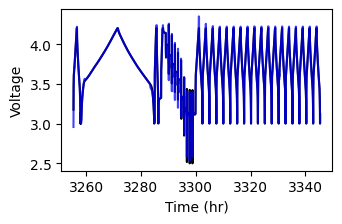

In [25]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, initial_cycles['voltage'], 'k')
ax.plot(initial_cycles['test_time'] / 3600, ukf_sim_voltages, 'b', alpha=0.75)

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Voltage')

The UKF adjusts the evolution of the model simulating the battery such it better matches observations.
In our case, it asjusting the estimated state of charge

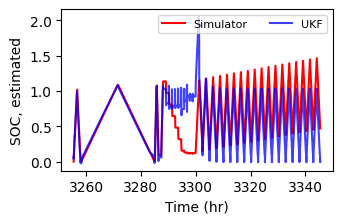

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

ax.plot(initial_cycles['test_time'] / 3600, sim_soc, 'r', label='Simulator')
ax.plot(initial_cycles['test_time'] / 3600, ukf_sim_soc, 'b', alpha=0.75, label='UKF')

ax.set_xlabel('Time (hr)')
ax.set_ylabel('SOC, estimated')
ax.legend(ncols=2, fontsize=8)

Note how the simulator suggests that the state-of-charge of the battery must be far greater than one given the observed current.
The UKF, instead, reports that the SOC is closer to 1 given the observed current _and voltage_.

## Estimating Advanced State of Health
We don't need to assume that the parameters of the battery model state fixed over time.
Rather, we can treat the values of parameters as an Advanced State of Health metric and estimate how they evolve over time.

The first step in doing so with Moirae is to mark the health parameters as "updatable." We'll mark the theoretical capacity as one of those parameters

In [27]:
asoh.mark_updatable('q_t.base_values')
asoh.updatable_names

('q_t.base_values',)

There ~~are~~ will be numerous ways in Moirae to learn how the health parameters vary over time. 
A simple one is to treat them the same as any other state of the system, which we refer to as a "joint" estimation (hence the Joint in JointUnscentedKalmanFilter)

In [28]:
ukf = JointEstimator.initialize_unscented_kalman_filter(
    cell_model=ECM(),
    initial_asoh=asoh,
    initial_inputs=ECMInput(time=0., current=0, temperature=25),
    initial_transients=ECMTransientVector(soc=0.),
    covariance_joint=np.diag([0.1, 0.1, 0.001])  # We add another parameter to account for the new variable
)

In [29]:
ukf.state_names

('soc', 'hyst', 'q_t.base_values')

Let's run with the entire dataset

In [30]:
%%time
states, _ = run_online_estimate(dataset, ukf, pbar=True)

100%|██████████| 110705/110705 [01:00<00:00, 1835.98it/s]

CPU times: user 59.2 s, sys: 2.65 s, total: 1min 1s
Wall time: 1min


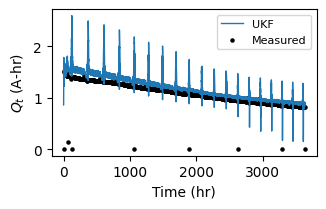

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 2.2))

ax.plot(dataset.raw_data['test_time'] / 3600, states['q_t.base_values'], lw=1, label='UKF')
ax.scatter(dataset.cycle_stats['cycle_start'] / 3600, dataset.cycle_stats['capacity_charge'], color='k', s=5, label='Measured')

ax.legend(fontsize=8)
ax.set_ylabel('$Q_t$ (A-hr)')
ax.set_xlabel('Time (hr)')

fig.tight_layout()

It works, but the joint estimator leaves for improvement. The capacity parameter of the model ($Q_t$) changes over short timescales, which is unrealistic and something we'll improve upon in more advanced estimators.